## Data Cleaning & EDA
---

In [7]:
import pandas as pd 
import geopandas as gpd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from keplergl import KeplerGl
import plotly_express as px 
import plotly.graph_objects as go
from shapely import wkt 
from shapely.geometry import Polygon, Point

plt.style.use('ggplot')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [18]:
data = pd.read_csv('boston_crime_data.csv')

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
data.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92102201,3301,NaN,VERBAL DISPUTE,E13,583,0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,DAY ST,42.325122,-71.107779,"(42.32512200, -71.10777900)"
2,I92097173,3115,NaN,INVESTIGATE PERSON,C11,355,0,2019-10-23 00:00:00,2019,10,Wednesday,0,NaN,GIBSON ST,42.297555,-71.059709,"(42.29755500, -71.05970900)"
3,I92094519,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0,2019-11-22 07:50:00,2019,11,Friday,7,NaN,BROOKS ST,42.355120,-71.162678,"(42.35512000, -71.16267800)"
4,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,42.309718,-71.104294,"(42.30971800, -71.10429400)"


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488822 entries, 0 to 488821
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   incident_number      488822 non-null  object 
 1   offense_code         488822 non-null  int64  
 2   offense_code_group   426089 non-null  object 
 3   offense_description  488822 non-null  object 
 4   district             486399 non-null  object 
 5   reporting_area       488822 non-null  object 
 6   shooting             64113 non-null   object 
 7   occurred_on_date     488822 non-null  object 
 8   year                 488822 non-null  int64  
 9   month                488822 non-null  int64  
 10  day_of_week          488822 non-null  object 
 11  hour                 488822 non-null  int64  
 12  ucr_part             425983 non-null  object 
 13  street               470943 non-null  object 
 14  lat                  460390 non-null  float64
 15  long             

In [21]:
data.shape

(488822, 17)

In [22]:
# Unique Incidents
data['incident_number'].nunique()

438323

In [23]:
data.drop(columns=['incident_number', 
                   'location'], inplace=True)

In [24]:
# Converting occurrance date to pandas datetime format
data['occurred_on_date'] = pd.to_datetime(data['occurred_on_date']) 

In [25]:
# checking nulls
data.isnull().sum()

offense_code                0
offense_code_group      62733
offense_description         0
district                 2423
reporting_area              0
shooting               424709
occurred_on_date            0
year                        0
month                       0
day_of_week                 0
hour                        0
ucr_part                62839
street                  17879
lat                     28432
long                    28432
dtype: int64

In [26]:
# Dropping crimes located outside boston
external = data.loc[data['district'] == 'External']

data.drop(external.index, axis=0, inplace=True)

In [27]:
data['reporting_area'].nunique()

880

In [28]:
# groupby Reporting Area and take the average of Long and Lat
reporting_area_centers = data[~data['lat'].isna()].groupby('reporting_area')['lat', 'long'].mean().reset_index()

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [29]:
# reporting_area_centers['geom'] = gpd.GeoSeries([Point(x, y) for x, y in zip(reporting_area_centers['lat'], reporting_area_centers['long'])])

In [42]:
# create a WKT representation of Reporting Area Centers: Lat/Lon values
reporting_area_centers["geom"]=reporting_area_centers.loc[:,["long","lat"]].apply(lambda x: "POINT("+str(x["long"])+" "+str(x["lat"])+")",axis=1)

In [43]:
reporting_area_centers.shape

(880, 5)

In [44]:
# there are some outliers, we need to remove them
reporting_area_centers.head()

,reporting_area,lat,long,geom,geometry
0,,38.208458,-64.418793,POINT(-64.41879255800197 38.208457994891496),POINT (38.20846 -64.41879)
1,000,-1.000000,-1.000000,POINT(-1.0 -1.0),POINT (-1.00000 -1.00000)
2,1,42.390204,-70.996719,POINT(-70.9967187307273 42.39020399909089),POINT (42.39020 -70.99672)
3,10,42.388745,-71.008474,POINT(-71.00847405534289 42.38874486606501),POINT (42.38874 -71.00847)
4,100,42.357900,-71.054753,POINT(-71.05475322458682 42.35789957921487),POINT (42.35790 -71.05475)


In [45]:
map_1 = KeplerGl(height=500)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [47]:
# Create a geopandas dataframe. use tract_geom column for geometry.
geodf_ra = gpd.GeoDataFrame(reporting_area_centers, geometry = reporting_area_centers['geom'].apply(wkt.loads))

In [48]:
geodf_ra.head()

,reporting_area,lat,long,geom,geometry
0,,38.208458,-64.418793,POINT(-64.41879255800197 38.208457994891496),POINT (-64.41879 38.20846)
1,000,-1.000000,-1.000000,POINT(-1.0 -1.0),POINT (-1.00000 -1.00000)
2,1,42.390204,-70.996719,POINT(-70.9967187307273 42.39020399909089),POINT (-70.99672 42.39020)
3,10,42.388745,-71.008474,POINT(-71.00847405534289 42.38874486606501),POINT (-71.00847 42.38874)
4,100,42.357900,-71.054753,POINT(-71.05475322458682 42.35789957921487),POINT (-71.05475 42.35790)


In [49]:
# Add data to Kepler Map
map_1.add_data(data=geodf_ra, name="boston_crime")

In [50]:
map_1

KeplerGl(data={'boston_crime': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

**Clearly there are outlying points that are incorrect.  Lets remove them.**



In [51]:
# reading boston neighborhood shape file
city_data = gpd.read_file('500Cities_City_11082016/CityBoundaries.shp')

In [52]:
city_data.crs

{'init': 'epsg:3857'}

In [53]:
city_data['geometry'] = city_data['geometry'].to_crs(epsg=4326)

In [56]:
boston_shp = city_data.loc[city_data['NAME'] == 'Boston', :]

In [57]:
boston_shp.head()

,NAME,CLASS,ST,STFIPS,PLACEFIPS,POP2010,STPLFIPS,geometry
79,Boston,city,MA,25,07000,617594,2507000,"MULTIPOLYGON (((-71.05067 42.27752, -71.05092 ..."


In [62]:
geodf_ra.head()

,reporting_area,lat,long,geom,geometry
0,,38.208458,-64.418793,POINT(-64.41879255800197 38.208457994891496),POINT (-64.41879 38.20846)
1,000,-1.000000,-1.000000,POINT(-1.0 -1.0),POINT (-1.00000 -1.00000)
2,1,42.390204,-70.996719,POINT(-70.9967187307273 42.39020399909089),POINT (-70.99672 42.39020)
3,10,42.388745,-71.008474,POINT(-71.00847405534289 42.38874486606501),POINT (-71.00847 42.38874)
4,100,42.357900,-71.054753,POINT(-71.05475322458682 42.35789957921487),POINT (-71.05475 42.35790)


In [63]:
geodf_ra_inboston = gpd.sjoin(geodf_ra,
                              boston_shp,
                              how='inner',
                              op='within')

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:3857'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [64]:
geodf_ra_inboston.shape

(865, 13)

In [66]:
geodf_ra_inboston.head()

,reporting_area,lat,long,geom,geometry,index_right,NAME,CLASS,ST,STFIPS,PLACEFIPS,POP2010,STPLFIPS
2,1,42.390204,-70.996719,POINT(-70.9967187307273 42.39020399909089),POINT (-70.99672 42.39020),79,Boston,city,MA,25,07000,617594,2507000
3,10,42.388745,-71.008474,POINT(-71.00847405534289 42.38874486606501),POINT (-71.00847 42.38874),79,Boston,city,MA,25,07000,617594,2507000
4,100,42.357900,-71.054753,POINT(-71.05475322458682 42.35789957921487),POINT (-71.05475 42.35790),79,Boston,city,MA,25,07000,617594,2507000
5,101,42.357647,-71.054113,POINT(-71.05411256057393 42.357646679987276),POINT (-71.05411 42.35765),79,Boston,city,MA,25,07000,617594,2507000
6,102,42.356400,-71.061460,POINT(-71.06145962225473 42.3564002266129),POINT (-71.06146 42.35640),79,Boston,city,MA,25,07000,617594,2507000


In [67]:
reporting_area_centers = reporting_area_centers.loc[reporting_area_centers['reporting_area'].isin(geodf_ra_inboston['reporting_area']),:]

In [70]:
reporting_area_centers.drop('geometry', axis=1, inplace=True)

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [71]:
map_2 = KeplerGl(height=500)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [73]:
# Add data to Kepler
map_2.add_data(data=reporting_area_centers, name="boston_crime")
# Add data to Kepler
map_2.add_data(data=boston_shp, name="boston_polygon")

In [74]:
map_2

KeplerGl(data={'boston_crime': {'index': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, …

### K-Means Clustering to Reduce Number of Reporting Centers

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [76]:
reporting_area_centers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 2 to 879
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reporting_area  865 non-null    object 
 1   lat             865 non-null    float64
 2   long            865 non-null    float64
 3   geom            865 non-null    object 
dtypes: float64(2), object(2)
memory usage: 73.8+ KB


In [78]:
# create 500 centers
clusters = KMeans(n_clusters=500).fit_predict(reporting_area_centers[['long', 'lat']])

In [79]:
# create cluster column
reporting_area_centers['reporting_cluster'] = clusters

In [80]:
# calculate mean lat for each cluster
reporting_area_centers_clusters=reporting_area_centers.groupby('reporting_cluster')['lat'].mean().reset_index()

In [81]:
# add average Long 
reporting_area_centers_clusters = pd.merge(reporting_area_centers_clusters,reporting_area_centers.groupby('reporting_cluster')['long'].mean().reset_index(),on='reporting_cluster')

In [82]:
reporting_area_centers_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   reporting_cluster  500 non-null    int64  
 1   lat                500 non-null    float64
 2   long               500 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 35.6 KB


In [87]:
map_3 = KeplerGl(height=500)
map_3.add_data(data=reporting_area_centers_clusters, name="rac_clusters")
map_3.add_data(data=boston_shp, name="boston_polygon")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [89]:
map_3

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ybahwr9', 'type': …

In [92]:
# reporting_area_centers.to_csv('reporting_area_centers.csv', index=False)

In [93]:
reporting_area_centers.head()

,reporting_area,lat,long,geom,reporting_cluster
2,1,42.390204,-70.996719,POINT(-70.9967187307273 42.39020399909089),211
3,10,42.388745,-71.008474,POINT(-71.00847405534289 42.38874486606501),371
4,100,42.357900,-71.054753,POINT(-71.05475322458682 42.35789957921487),85
5,101,42.357647,-71.054113,POINT(-71.05411256057393 42.357646679987276),85
6,102,42.356400,-71.061460,POINT(-71.06145962225473 42.3564002266129),165


In [99]:
data = data.loc[data['reporting_area'].isin(reporting_area_centers['reporting_area']), :]

In [111]:
# adding clusters to crime data
data = pd.merge(data, reporting_area_centers[['reporting_area', 'reporting_cluster']], on='reporting_area')

In [112]:
data.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,reporting_cluster
0,3301,NaN,VERBAL DISPUTE,E13,583,0.0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,DAY ST,42.325122,-71.107779,497
1,1402,Vandalism,VANDALISM,E13,583,0.0,2019-09-22 19:20:00,2019,9,Sunday,19,Part Two,ROUND HILL ST,42.324692,-71.106189,497
2,3301,Verbal Disputes,VERBAL DISPUTE,E13,583,0.0,2019-09-22 22:42:00,2019,9,Sunday,22,Part Three,ROUND HILL ST,42.324692,-71.106189,497
3,802,Simple Assault,ASSAULT SIMPLE - BATTERY,E13,583,0.0,2019-09-22 19:32:00,2019,9,Sunday,19,Part Two,GAY HEAD ST,42.324248,-71.105252,497
4,3114,Investigate Property,INVESTIGATE PROPERTY,E13,583,0.0,2019-09-15 18:05:37,2019,9,Sunday,18,Part Three,GAY HEAD ST,42.325064,-71.104900,497


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448803 entries, 0 to 448802
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   offense_code         448803 non-null  int64         
 1   offense_code_group   393043 non-null  object        
 2   offense_description  448803 non-null  object        
 3   district             448771 non-null  object        
 4   reporting_area       448803 non-null  object        
 5   shooting             448803 non-null  float64       
 6   occurred_on_date     448803 non-null  datetime64[ns]
 7   year                 448803 non-null  int64         
 8   month                448803 non-null  int64         
 9   day_of_week          448803 non-null  object        
 10  hour                 448803 non-null  int64         
 11  ucr_part             392940 non-null  object        
 12  street               445446 non-null  object        
 13  lat           

In [129]:
data_offense_codes = data.groupby(['offense_code_group']).size().reset_index()
data_offense_codes

,offense_code_group,0
0,Aggravated Assault,9765
1,Aircraft,48
2,Arson,106
3,Assembly or Gathering Violations,1069
4,Auto Theft,5860
5,Auto Theft Recovery,1299
6,Ballistics,1261
7,Biological Threat,3
8,Bomb Hoax,99
9,Burglary - No Property Taken,2


In [119]:
# Unique offenses
data['offense_description'].nunique()

280

In [120]:
data['ucr_part'].unique()

array([nan, 'Part Two', 'Part Three', 'Part One', 'Other'], dtype=object)

In [121]:
part_one = data.loc[data['ucr_part'] == 'Part One', :]

In [122]:
part_one.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,reporting_cluster
15,616,Larceny,LARCENY THEFT OF BICYCLE,E13,583,0.0,2019-07-20 18:00:00,2019,7,Saturday,18,Part One,EDGE HILL ST,42.324231,-71.106422,497
22,613,Larceny,LARCENY SHOPLIFTING,E13,583,0.0,2019-06-21 12:56:00,2019,6,Friday,12,Part One,GAY HEAD ST,42.324741,-71.104919,497
23,613,Larceny,LARCENY SHOPLIFTING,E13,583,0.0,2019-06-19 11:55:00,2019,6,Wednesday,11,Part One,HEATH ST,42.326655,-71.106796,497
26,619,Larceny,LARCENY ALL OTHERS,E13,583,0.0,2019-06-09 07:50:00,2019,6,Sunday,7,Part One,ROUND HILL ST,42.324692,-71.106189,497
29,614,Larceny From Motor Vehicle,LARCENY THEFT FROM MV - NON-ACCESSORY,E13,583,0.0,2019-06-04 20:30:00,2019,6,Tuesday,20,Part One,MINDEN ST,42.325360,-71.106480,497


In [123]:
data['shooting'] = data['shooting'].map({'Y':1, 1.0:1, 0.0:0})
data['shooting'].fillna(0, inplace=True)

In [124]:
part_one['offense_description'].value_counts().sort_index()

A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.           1
ASSAULT & BATTERY D/W - KNIFE                          1
ASSAULT & BATTERY D/W - OTHER                          6
ASSAULT & BATTERY D/W - OTHER ON POLICE OFFICER        1
ASSAULT - AGGRAVATED                                3692
ASSAULT - AGGRAVATED - BATTERY                      6062
ASSAULT D/W - KNIFE ON POLICE OFFICER                  1
ASSAULT D/W - OTHER                                    1
AUTO THEFT                                          4292
AUTO THEFT - LEASED/RENTED VEHICLE                   513
AUTO THEFT - MOTORCYCLE / SCOOTER                   1051
AUTO THEFT - RECOVERED IN BY POLICE                    2
AUTO THEFT LEASE/RENT VEHICLE                          1
AUTO THEFT OTHER                                       1
B&E NON-RESIDENCE DAY - FORCIBLE                       2
B&E NON-RESIDENCE DAY - NO FORCE                       2
B&E NON-RESIDENCE NIGHT - FORCE                        1
B&E RESIDENCE DAY - NO FORCE   

In [125]:
part_two = data.loc[data['ucr_part'] == 'Part Two', :]
part_two.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,reporting_cluster
1,1402,Vandalism,VANDALISM,E13,583,0,2019-09-22 19:20:00,2019,9,Sunday,19,Part Two,ROUND HILL ST,42.324692,-71.106189,497
3,802,Simple Assault,ASSAULT SIMPLE - BATTERY,E13,583,0,2019-09-22 19:32:00,2019,9,Sunday,19,Part Two,GAY HEAD ST,42.324248,-71.105252,497
5,2610,Other,TRESPASSING,E13,583,0,2019-09-09 13:01:00,2019,9,Monday,13,Part Two,EDGE HILL ST,42.324231,-71.106422,497
6,1402,Vandalism,VANDALISM,E13,583,0,2019-09-06 22:41:00,2019,9,Friday,22,Part Two,MINDEN ST,42.325360,-71.106480,497
8,2662,Ballistics,BALLISTICS EVIDENCE/FOUND,E13,583,0,2019-08-23 23:13:00,2019,8,Friday,23,Part Two,MINDEN ST,42.325125,-71.105205,497


In [126]:
part_two['offense_description'].value_counts().sort_index()

A&B ON POLICE OFFICER                                    3
ABDUCTION - INTICING                                    10
AFFRAY                                                 261
ANIMAL ABUSE                                            80
ANNOYING AND ACCOSTIN                                    1
ANNOYING AND ACCOSTING                                 136
ASSAULT & BATTERY                                        9
ASSAULT - SIMPLE                                      1287
ASSAULT SIMPLE - BATTERY                             18503
BALLISTICS EVIDENCE/FOUND                             1261
BIOLOGICAL THREATS                                       3
BOMB THREAT                                             99
CHILD ABANDONMENT (NO ASSAULT)                          64
CHILD ABUSE                                              1
CHILD ENDANGERMENT                                     294
CHILD ENDANGERMENT (NO ASSAULT)                        228
CHINS                                                   

In [24]:
part_three = data.loc[data['ucr_part'] == 'Part Three', :]
part_three.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long
35,3114,Investigate Property,INVESTIGATE PROPERTY,B3,427,NaN,2019-09-29 06:39:00,2019,9,Sunday,6,Part Three,WILMORE ST,42.277964,-71.092463
36,3115,Investigate Person,INVESTIGATE PERSON,A1,,NaN,2019-09-29 03:45:00,2019,9,Sunday,3,Part Three,NASHUA ST,42.367690,-71.065863
37,3301,Verbal Disputes,VERBAL DISPUTE,B3,450,NaN,2019-09-29 06:00:00,2019,9,Sunday,6,Part Three,ASPINWALL RD,42.291816,-71.072441
39,3820,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,D4,269,NaN,2019-09-29 05:50:00,2019,9,Sunday,5,Part Three,ALBANY ST,42.332419,-71.075013
40,3115,Investigate Person,INVESTIGATE PERSON,A7,28,NaN,2019-09-29 01:30:00,2019,9,Sunday,1,Part Three,PARIS ST,42.373392,-71.036478


In [25]:
part_three['offense_description'].value_counts().sort_index()

AIRCRAFT INCIDENTS                                    45
ANIMAL CONTROL - DOG BITES - ETC.                    409
ANIMAL INCIDENTS                                     303
DANGEROUS OR HAZARDOUS CONDITION                     287
DEATH INVESTIGATION                                 1345
DEMONSTRATIONS/RIOT                                  225
EXPLOSIVES - TURNED IN OR FOUND                       13
FIRE REPORT - CAR, BRUSH, ETC.                       512
FIRE REPORT - HOUSE, BUILDING, ETC.                 1451
FIREARM/WEAPON - ACCIDENTAL INJURY / DEATH            10
FIREARM/WEAPON - FOUND OR CONFISCATED                676
FIREARM/WEAPON - LOST                                 12
GATHERING CAUSING ANNOYANCE                           12
HARBOR INCIDENT / VIOLATION                          175
INJURY BICYCLE NO M/V INVOLVED                        48
INTIMIDATING WITNESS                                 326
INVESTIGATE PERSON                                 21358
INVESTIGATE PROPERTY           

In [26]:
part_other = data.loc[data['ucr_part'] == 'Other', :]
part_other.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long
833,735,Auto Theft Recovery,RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUT...,C11,392,NaN,2019-09-26 10:27:00,2019,9,Thursday,10,Other,ASHMONT ST,42.287346,-71.058187
873,735,Auto Theft Recovery,RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUT...,C11,454,NaN,2019-09-26 08:40:00,2019,9,Thursday,8,Other,WASHINGTON ST,42.300226,-71.074683
880,735,Auto Theft Recovery,RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUT...,D4,167,NaN,2019-09-25 19:00:00,2019,9,Wednesday,19,Other,E BROOKLINE ST,42.337635,-71.070130
1438,735,Auto Theft Recovery,RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUT...,B2,317,NaN,2019-09-24 12:10:00,2019,9,Tuesday,12,Other,HOMESTEAD ST,42.311277,-71.089093
1502,735,Auto Theft Recovery,RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUT...,C11,344,NaN,2019-09-24 08:47:00,2019,9,Tuesday,8,Other,CORONA ST,42.301462,-71.068960


In [27]:
part_other['offense_description'].value_counts().sort_index()


ARSON                                                           94
AUTO THEFT - OUTSIDE - RECOVERED IN BOSTON                       1
B&E RESIDENCE DAY - NO PROP TAKEN                                3
KILLING OF FELON BY POLICE                                       1
MANSLAUGHTER - NON-VEHICLE - NEGLIGENCE                          2
MANSLAUGHTER - VEHICLE - NEGLIGENCE                              6
PROPERTY - CONCEALING LEASED                                    36
RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUTSIDE BOSTON)    1155
RECOVERED STOLEN PLATE                                          75
Name: offense_description, dtype: int64

In [130]:
data['ucr_part'].fillna('unknown', inplace=True)


part_unknown = data.loc[data['ucr_part'] == 'unknown', :]
part_unknown.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,reporting_cluster
0,3301,NaN,VERBAL DISPUTE,E13,583,0,2019-12-20 03:08:00,2019,12,Friday,3,unknown,DAY ST,42.325122,-71.107779,497
255,614,NaN,LARCENY THEFT FROM MV - NON-ACCESSORY,E13,583,0,2020-06-08 05:39:00,2020,6,Monday,5,unknown,SCHILLER ST,42.325642,-71.105357,497
256,3006,NaN,SICK/INJURED/MEDICAL - PERSON,E13,583,0,2020-05-30 23:00:00,2020,5,Saturday,23,unknown,WALDEN ST,42.324754,-71.104252,497
257,3114,NaN,INVESTIGATE PROPERTY,E13,583,0,2020-05-29 10:36:00,2020,5,Friday,10,unknown,ROUND HILL ST,42.324691,-71.106189,497
258,617,NaN,LARCENY THEFT FROM BUILDING,E13,583,0,2020-05-09 16:30:00,2020,5,Saturday,16,unknown,MINDEN ST,42.325359,-71.106480,497


In [150]:
part_unknown['offense_description'].value_counts().sort_index()

AFFRAY                                                                                24
AIRCRAFT INCIDENTS                                                                    10
ANIMAL ABUSE                                                                           7
ANIMAL INCIDENTS (DOG BITES, LOST DOG, ETC)                                           69
ARSON                                                                                 17
ASSAULT - AGGRAVATED                                                                1469
ASSAULT - SIMPLE                                                                    3563
AUTO THEFT                                                                           655
AUTO THEFT - LEASED/RENTED VEHICLE                                                    67
AUTO THEFT - MOTORCYCLE / SCOOTER                                                    105
BALLISTICS EVIDENCE/FOUND                                                            174
BIOLOGICAL THREATS   

In [149]:
data.loc[data['offense_description'].str.contains('sex offense', case=False), :]['offense_code_group'].fillna('SEX OFFENSE', inplace=True)

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [30]:
data['ucr_part'].value_counts()

Part Three    176583
Part Two      104713
Part One       65390
unknown        61552
Other           1373
Name: ucr_part, dtype: int64

In [31]:
data['is_auto_theft'] = data['offense_description'].str.contains('Auto Theft', case=False).map({True:1, False:0})

In [32]:
data['is_robbery'] = data['offense_description'].str.contains('Robbery', case=False).map({True:1, False:0})

In [33]:
data['is_larceny'] = data['offense_description'].str.contains('Larceny', case=False).map({True:1, False:0})

In [34]:
burglary_or_be = ['burglary', 'b&e']

data['is_burglary'] = data['offense_description'].str.contains('|'.join(burglary_or_be), case=False).map({True:1, False:0})


In [35]:
data['is_drug'] = data['offense_description'].str.contains('drug', case=False).map({True:1, False:0})

In [37]:
data['is_sexual_assault'] = data['offense_description'].str.contains('sex offense', case=False).map({True:1, False:0})

In [38]:
data['is_weapon'] = data['offense_description'].str.contains('weapon', case=False).map({True:1, False:0})

In [39]:
data['is_aggrevated_assault'] = data['offense_description'].str.contains('assault', case=False).map({True:1, False:0})

In [40]:
data['is_murder'] = data['offense_description'].str.contains('murder', case=False).map({True:1, False:0})

In [41]:
data.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,is_auto_theft,is_robbery,is_larceny,is_burglary,is_drug,is_sexual_assault,is_weapon,is_aggrevated_assault,is_murder
1,3301,NaN,VERBAL DISPUTE,E13,583,0.0,2019-12-20 03:08:00,2019,12,Friday,3,unknown,DAY ST,42.325122,-71.107779,0,0,0,0,0,0,0,0,0
2,3115,NaN,INVESTIGATE PERSON,C11,355,0.0,2019-10-23 00:00:00,2019,10,Wednesday,0,unknown,GIBSON ST,42.297555,-71.059709,0,0,0,0,0,0,0,0,0
3,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0.0,2019-11-22 07:50:00,2019,11,Friday,7,unknown,BROOKS ST,42.355120,-71.162678,0,0,0,0,0,0,0,0,0
4,3005,NaN,SICK ASSIST,E13,574,0.0,2019-11-05 18:00:00,2019,11,Tuesday,18,unknown,WASHINGTON ST,42.309718,-71.104294,0,0,0,0,0,0,0,0,0
5,1402,NaN,VANDALISM,E18,498,0.0,2019-11-02 05:09:00,2019,11,Saturday,5,unknown,BRADLEE ST,42.271616,-71.118074,0,0,0,0,0,0,0,0,0


In [42]:
data.isnull().sum()

offense_code                 0
offense_code_group       61445
offense_description          0
district                  1905
reporting_area               0
shooting                     0
occurred_on_date             0
year                         0
month                        0
day_of_week                  0
hour                         0
ucr_part                     0
street                    7943
lat                          0
long                         0
is_auto_theft                0
is_robbery                   0
is_larceny                   0
is_burglary                  0
is_drug                      0
is_sexual_assault            0
is_weapon                    0
is_aggrevated_assault        0
is_murder                    0
dtype: int64

In [43]:
# data.drop('shooting', axis=1, inplace=True)

In [44]:
data.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,is_auto_theft,is_robbery,is_larceny,is_burglary,is_drug,is_sexual_assault,is_weapon,is_aggrevated_assault,is_murder
1,3301,NaN,VERBAL DISPUTE,E13,583,0.0,2019-12-20 03:08:00,2019,12,Friday,3,unknown,DAY ST,42.325122,-71.107779,0,0,0,0,0,0,0,0,0
2,3115,NaN,INVESTIGATE PERSON,C11,355,0.0,2019-10-23 00:00:00,2019,10,Wednesday,0,unknown,GIBSON ST,42.297555,-71.059709,0,0,0,0,0,0,0,0,0
3,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0.0,2019-11-22 07:50:00,2019,11,Friday,7,unknown,BROOKS ST,42.355120,-71.162678,0,0,0,0,0,0,0,0,0
4,3005,NaN,SICK ASSIST,E13,574,0.0,2019-11-05 18:00:00,2019,11,Tuesday,18,unknown,WASHINGTON ST,42.309718,-71.104294,0,0,0,0,0,0,0,0,0
5,1402,NaN,VANDALISM,E18,498,0.0,2019-11-02 05:09:00,2019,11,Saturday,5,unknown,BRADLEE ST,42.271616,-71.118074,0,0,0,0,0,0,0,0,0


In [45]:
list(data.columns)

['offense_code',
 'offense_code_group',
 'offense_description',
 'district',
 'reporting_area',
 'shooting',
 'occurred_on_date',
 'year',
 'month',
 'day_of_week',
 'hour',
 'ucr_part',
 'street',
 'lat',
 'long',
 'is_auto_theft',
 'is_robbery',
 'is_larceny',
 'is_burglary',
 'is_drug',
 'is_sexual_assault',
 'is_weapon',
 'is_aggrevated_assault',
 'is_murder']

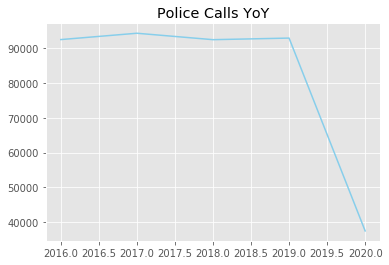

In [46]:
data['year'].value_counts().sort_index().plot(kind='line', color='skyblue')
plt.title('Police Calls YoY');

''

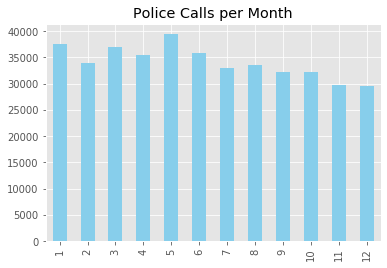

In [47]:
data['month'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Police Calls per Month')
;

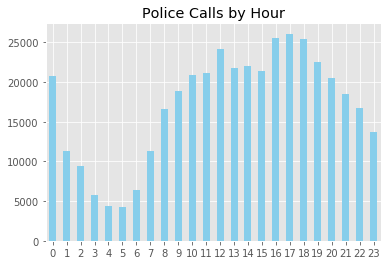

In [48]:
data['hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Police Calls by Hour')
plt.xticks(rotation='horizontal');


In [49]:
data['day_of_week'] = pd.Categorical(data['day_of_week'], 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

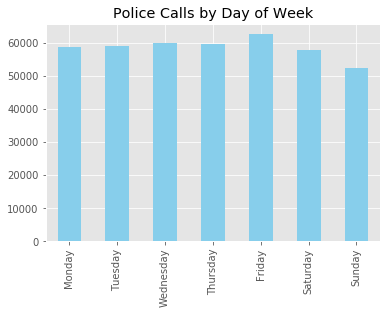

In [50]:
data['day_of_week'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Police Calls by Day of Week');

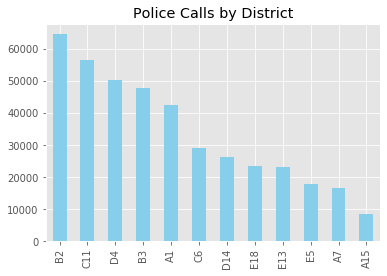

In [51]:
data['district'].value_counts().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Police Calls by District');

In [52]:
data.head()

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,is_auto_theft,is_robbery,is_larceny,is_burglary,is_drug,is_sexual_assault,is_weapon,is_aggrevated_assault,is_murder
1,3301,NaN,VERBAL DISPUTE,E13,583,0.0,2019-12-20 03:08:00,2019,12,Friday,3,unknown,DAY ST,42.325122,-71.107779,0,0,0,0,0,0,0,0,0
2,3115,NaN,INVESTIGATE PERSON,C11,355,0.0,2019-10-23 00:00:00,2019,10,Wednesday,0,unknown,GIBSON ST,42.297555,-71.059709,0,0,0,0,0,0,0,0,0
3,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0.0,2019-11-22 07:50:00,2019,11,Friday,7,unknown,BROOKS ST,42.355120,-71.162678,0,0,0,0,0,0,0,0,0
4,3005,NaN,SICK ASSIST,E13,574,0.0,2019-11-05 18:00:00,2019,11,Tuesday,18,unknown,WASHINGTON ST,42.309718,-71.104294,0,0,0,0,0,0,0,0,0
5,1402,NaN,VANDALISM,E18,498,0.0,2019-11-02 05:09:00,2019,11,Saturday,5,unknown,BRADLEE ST,42.271616,-71.118074,0,0,0,0,0,0,0,0,0


In [53]:
violent_related = data[[ 'is_auto_theft',
 'is_robbery',
 'is_larceny',
 'is_burglary',
 'is_drug',
 'is_sexual_assault',
 'is_weapon',
 'is_aggrevated_assault',
 'is_murder', 
 'shooting']]

In [54]:
data['is_violent'] = violent_related.sum(axis=1)

In [55]:
data.shape

(409611, 25)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409611 entries, 1 to 489571
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   offense_code           409611 non-null  int64         
 1   offense_code_group     348166 non-null  object        
 2   offense_description    409611 non-null  object        
 3   district               407706 non-null  object        
 4   reporting_area         409611 non-null  object        
 5   shooting               409611 non-null  float64       
 6   occurred_on_date       409611 non-null  datetime64[ns]
 7   year                   409611 non-null  int64         
 8   month                  409611 non-null  int64         
 9   day_of_week            409611 non-null  category      
 10  hour                   409611 non-null  int64         
 11  ucr_part               409611 non-null  object        
 12  street                 401668 non-null  obje

In [57]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
offense_code,409611.0,2332.329088,1175.424895,111.000000,1102.000000,3006.000000,3201.000000,3831.000000
shooting,409611.0,0.005036,0.070789,0.000000,0.000000,0.000000,0.000000,1.000000
year,409611.0,2017.727832,1.285221,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000
month,409611.0,6.261861,3.404410,1.000000,3.000000,6.000000,9.000000,12.000000
hour,409611.0,13.106694,6.316336,0.000000,9.000000,14.000000,18.000000,23.000000
lat,409611.0,42.228220,2.010579,-1.000000,42.296661,42.324923,42.348288,42.395042
long,409611.0,-70.932001,3.252455,-71.178674,-71.097567,-71.077763,-71.062563,0.000000
is_auto_theft,409611.0,0.014028,0.117606,0.000000,0.000000,0.000000,0.000000,1.000000
is_robbery,409611.0,0.012402,0.110672,0.000000,0.000000,0.000000,0.000000,1.000000
is_larceny,409611.0,0.113298,0.316957,0.000000,0.000000,0.000000,0.000000,1.000000


In [58]:
crime_types = data[[ 
 'is_auto_theft',
 'is_robbery',
 'is_larceny',
 'is_burglary',
 'is_drug',
 'is_sexual_assault',
 'is_weapon',
 'is_aggrevated_assault',
 'is_murder',
 'shooting']]

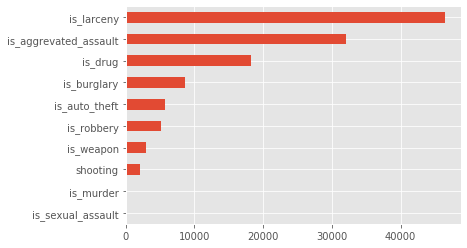

In [61]:
crime_types.sum().sort_values().plot(kind='barh');